In [295]:
from functools import reduce
from pathlib import Path
from collections import Counter
from dataclasses import dataclass

from fastai.basic_train import get_preds, LearnerCallback, Learner
from fastai.text import *
from fastai.datasets import *
from fastai.metrics import *
from fastai.train import *
from fastai.vision import *
from fastai.callback import Callback
from fastai.callbacks import SaveModelCallback
import pandas as pd

from fastai.imports import nn, torch
from sklearn import metrics
import sklearn.metrics
import altair as alt

import news_utils

%load_ext autoreload
%autoreload 2

alt.renderers.enable('notebook')
torch.cuda.set_device(3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [296]:
EX_PA = Path('/mnt/data/group07/johannes/ynacc_proc/clean_split/sentiment_maj/')
MODELS = Path('/mnt/data/group07/johannes/ynacc_proc/clean_split/lm_models/')
LM_DATA_PATH = Path('/mnt/data/group07/johannes/ynacc_proc/clean_split/lm_data/')

tokenizer = Tokenizer(special_cases = ['xxbos','xxfld','xxunk','xxpad', 'xxsep'])
# tokenizer = None

data_lm_train = pd.read_csv(LM_DATA_PATH/'train.csv')
data_lm_val = pd.read_csv(LM_DATA_PATH/'val.csv')

# Language model data
data_lm = TextLMDataBunch.from_df(LM_DATA_PATH, data_lm_train, data_lm_val, tokenizer=tokenizer)

In [297]:
data_clas_train = pd.read_csv(EX_PA/'train.csv')
data_clas_val = pd.read_csv(EX_PA/'val.csv')

data_clas = news_utils.RandomSampler.TextClasDataBunchRandom.from_df(EX_PA, data_clas_train, data_clas_val, vocab=data_lm.train_ds.vocab, bs=50, txt_cols=['text'], label_cols=['class'], num_samples=2000)

In [26]:
learn = language_model_learner(data_lm, pretrained_fnames=['lstm_wt103', 'itos_wt103'], drop_mult=0.5)

In [27]:
learn.fit_one_cycle(1, 1e-2)

Total time: 05:28
epoch  train_loss  valid_loss  accuracy
1      4.702953    4.542753    0.238456  (05:28)



In [28]:
# learn.load_encoder(MODELS/'ft_enc_05_30')
learn.unfreeze()
learn.fit_one_cycle(, 1e-3)

Total time: 06:23
epoch  train_loss  valid_loss  accuracy
1      4.388505    4.368560    0.254820  (06:23)



In [29]:
learn.save_encoder(MODELS/'06_11-_18')

In [3]:
# weights = [1,1, 1, 1]
# class_weights = torch.FloatTensor(weights).cuda()
# loss_func = nn.CrossEntropyLoss(weight=class_weights)

In [300]:
learn2 = text_classifier_learner(data_clas, drop_mult=1)
learn2.load_encoder(MODELS/'ft_enc_05_30_continued')

# F1 score and save only best f1 macro score
@dataclass
class F1Macro(Callback):
    name:str='F1_macro'
    
    def on_epoch_begin(self, **kwargs):
        self.y_pred, self.y_true = [], []
        
    def on_batch_end(self, last_output, last_target, **kwargs):
        _, idxs = torch.max(last_output, 1)
        self.y_pred += idxs.tolist()
        self.y_true += last_target.tolist()
    
    
    def on_epoch_end(self, **kwargs):
        f1_macro = sklearn.metrics.f1_score(self.y_pred, self.y_true, average='macro')
        self.metric = f1_macro

        
learn2.metrics = [F1Macro()]

learn2.callbacks += [SaveModelCallback(learn2, 'F1_macro', 'max', name='getreal5k')]

learn2.fit(5000, 1e-3)

Total time: 00:37
epoch  train_loss  valid_loss  F1_macro
1      1.395067    1.379233    0.264216  (00:03)
2      1.363853    1.329117    0.342595  (00:03)
3      1.339451    1.299924    0.362497  (00:04)
4      1.318701    1.253304    0.388479  (00:03)
5      1.322018    1.336017    0.338562  (00:03)
6      1.300833    1.265422    0.392110  (00:03)
7      1.308554    1.365137    0.342695  (00:04)
8      1.323317    1.379931    0.342914  (00:03)
9      1.310123    1.330880    0.366427  (00:03)
10     1.301714    1.320380    0.376746  (00:03)



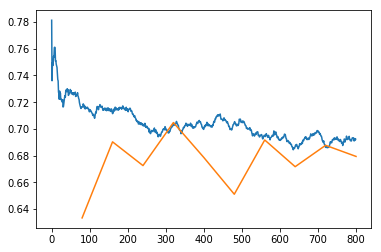

In [12]:
learn2.recorder.plot_losses()

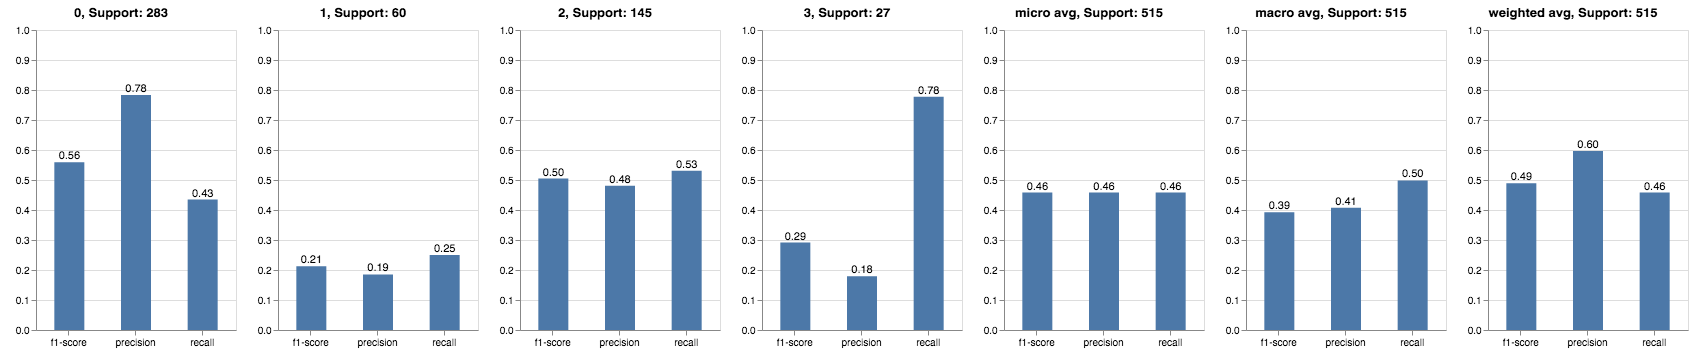

SankeyWidget(links=[{'source': 'true negative', 'target': 'pred negative', 'type': 'cor', 'value': 123}, {'sou…

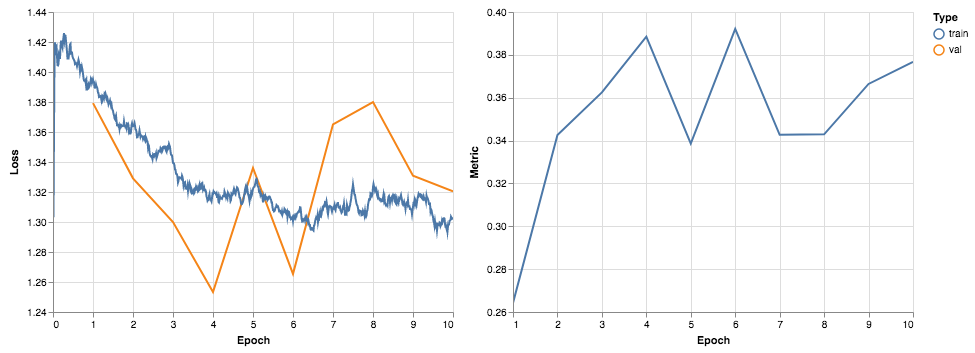

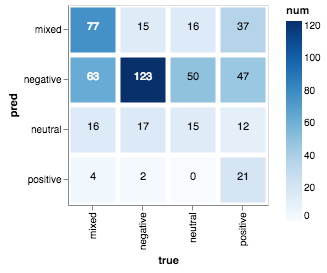

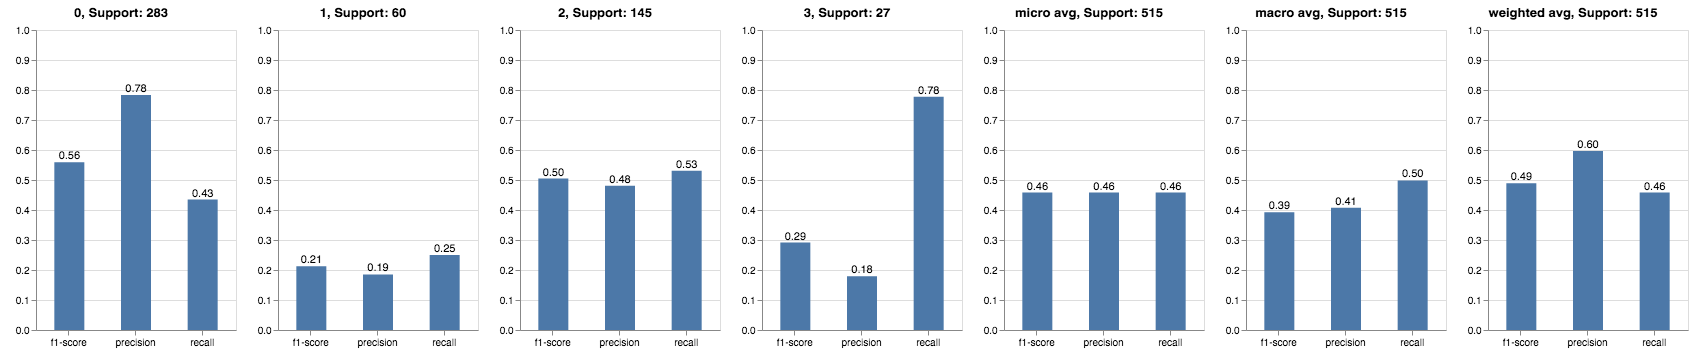

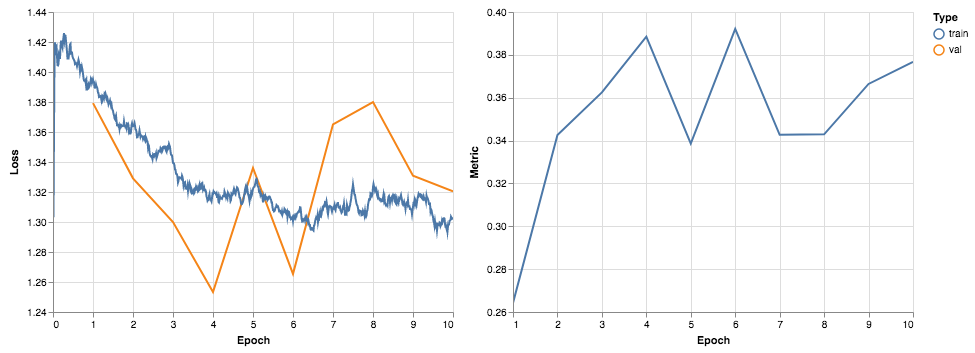

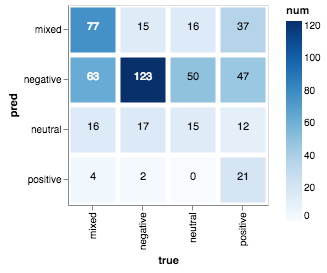

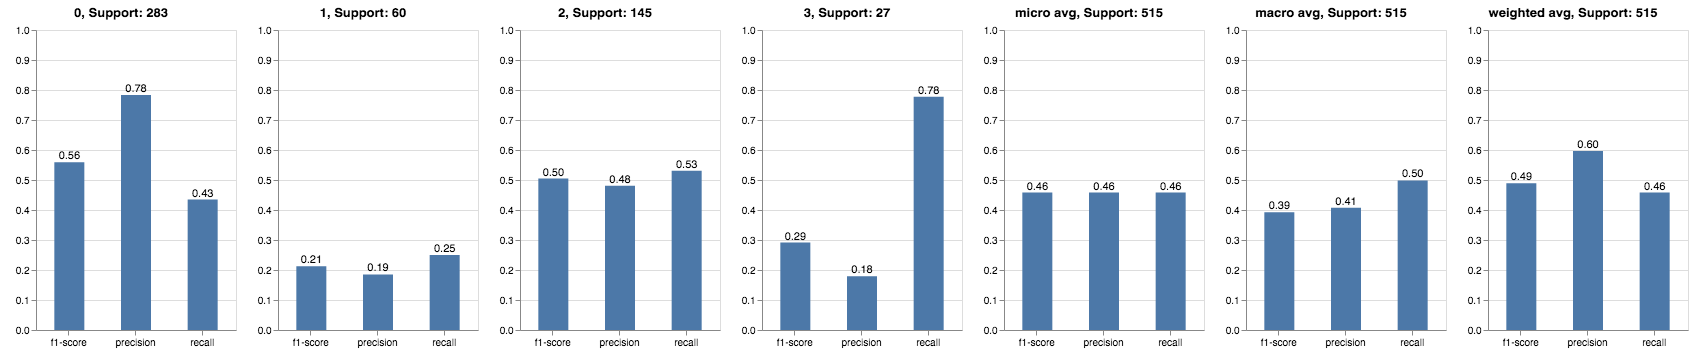

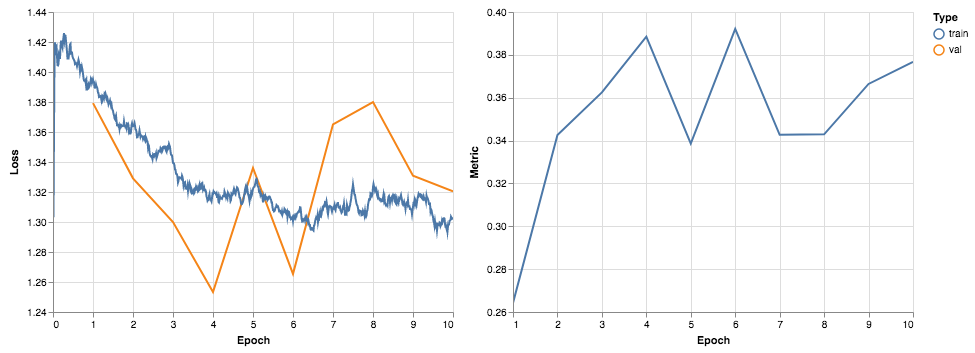

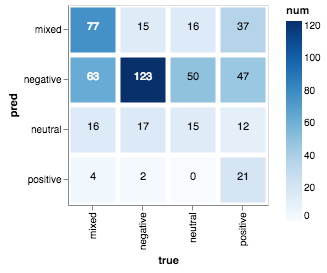

In [301]:
news_utils.plot.all(learn2, labels=['negative', 'neutral', 'mixed', 'positive'])

In [309]:
import news_utils

None

SankeyWidget(links=[{'source': 'true negative', 'target': 'pred negative', 'type': 'cor', 'value': 171}, {'sou…

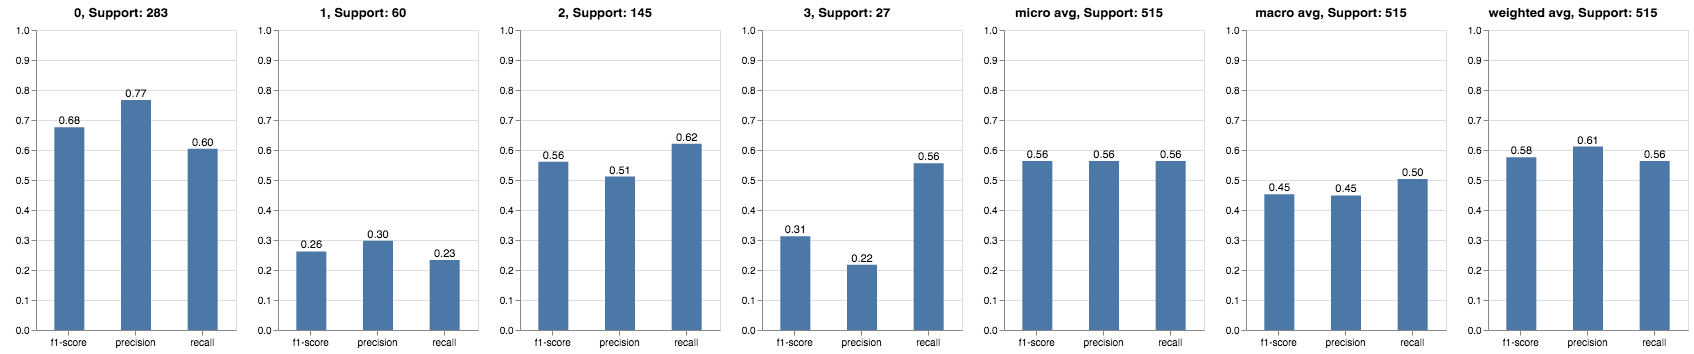

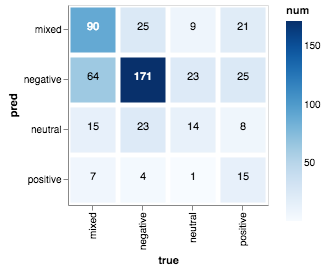

In [310]:
news_utils.plot.all(learn2, labels=['negative', 'neutral', 'mixed', 'positive'])